# Random Forest Regessor Base Model

## Package imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import ta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands

## Download Data

In [2]:
aapl_data = yf.download("AAPL", start="2018-01-01", end="2020-12-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.188164,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.180988,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.372284,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.843304,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.687893,82271200
...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.157623,88223700
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.161407,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.852509,124486200


## Plot the Adjusted Closing Price

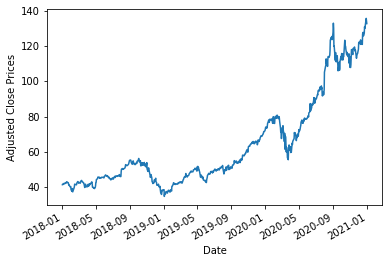

In [4]:
aapl_data['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

## % Change Histogram

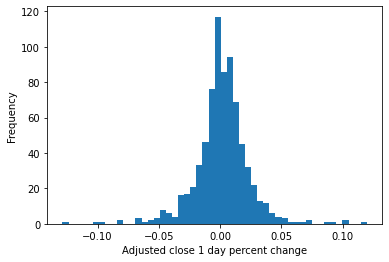

In [5]:
aapl_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

## Feature engineering with MA, RSI, Bollinger Band Width

In [6]:
feature_names = []
for n in [14, 30, 50, 200]:
    aapl_data[str(n) + 'd' + ' ma'] = SMAIndicator(aapl_data['Adj Close'], window=n).sma_indicator()
    aapl_data[str(n) + 'd' + ' rsi'] = RSIIndicator(aapl_data['Adj Close'], window=n).rsi()
    aapl_data[str(n) + 'd' + ' bbwidth'] = BollingerBands(aapl_data['Adj Close'], window=n).bollinger_wband()

    feature_names = feature_names + [str(n) + 'd' + ' ma' , str(n) + 'd' + ' rsi', str(n) + 'd' + ' bbwidth']

In [7]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,14d bbwidth,30d ma,30d rsi,30d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth
Date,,,,,,,,,,,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.188164,102223600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.180988,118071600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.372284,89738400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.843304,94640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.687893,82271200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,132.160004,132.429993,130.779999,130.960007,130.157623,88223700,125.065430,66.473387,10.617098,121.345267,60.588093,15.028687,118.721914,58.623999,17.663726,97.959237,57.312138,87.914476
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.161407,54930100,125.755461,67.920946,11.151013,121.758718,61.315716,15.960609,118.940341,59.063577,18.568891,98.308572,57.454609,87.476151
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.852509,124486200,126.674084,73.647437,13.464971,122.337815,64.485586,17.768002,119.262116,61.037552,20.148887,98.644645,58.111253,87.416680


In [8]:
aapl_data['1d_vol_change'] = aapl_data['Volume'].pct_change()

volume_features = ['1d_vol_change']
feature_names.extend(volume_features)

In [9]:
aapl_data['5d_future_close'] = aapl_data['Adj Close'].shift(-5)
aapl_data['5d_close_future_pct'] = aapl_data['5d_future_close'].pct_change(5) * 100

In [10]:
aapl_data.head(25)

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,14d bbwidth,30d ma,...,30d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,1d_vol_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.188164,102223600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.683113,NaN
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.180988,118071600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155033,41.673542,NaN
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.372284,89738400,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.239966,41.910252,NaN
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.843304,94640000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054621,42.343037,NaN
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.687893,82271200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.130693,42.127842,NaN
2018-01-09,43.637501,43.764999,43.352501,43.582500,41.683113,86336000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049407,42.823647,2.736200
2018-01-10,43.290001,43.575001,43.250000,43.572498,41.673542,95839600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110077,42.861900,2.851589
2018-01-11,43.647499,43.872501,43.622501,43.820000,41.910252,74670800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.220877,42.670620,1.814278
2018-01-12,44.044998,44.340000,43.912498,44.272499,42.343037,101672400,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361609,42.321518,-0.050820


## Drop NaN

In [11]:
aapl_data.dropna(inplace=True)
aapl_data

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,14d bbwidth,30d ma,...,30d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,1d_vol_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-16,54.732498,55.747501,54.189999,55.537498,53.727085,116736000,54.151190,50.940195,8.704698,53.811736,...,7.431349,53.120972,56.148580,11.525590,45.643911,56.906090,43.369754,-0.052191,53.867359,0.261086
2018-10-17,55.575001,55.660000,54.834999,55.297501,53.494911,91541600,54.086236,49.875801,8.783823,53.765946,...,7.302559,53.192578,55.695379,10.987394,45.705445,56.701404,43.492369,-0.215824,52.019623,-2.757811
2018-10-18,54.465000,54.935001,53.250000,54.005001,52.244545,130325200,53.918323,44.484879,9.402128,53.708869,...,7.581042,53.238503,53.329893,10.465531,45.760763,55.618602,43.535010,0.423672,53.158741,1.749840
2018-10-19,54.514999,55.314999,54.357498,54.827499,53.040234,132314800,53.780986,48.313488,9.302876,53.692826,...,7.632457,53.292484,54.582470,9.986365,45.819103,56.154111,43.624171,0.015266,52.312263,-1.372487
2018-10-22,54.947498,55.840000,54.735001,55.162498,53.364307,115168400,53.631902,49.831062,8.682812,53.711529,...,7.545258,53.355945,55.083480,9.405268,45.876708,56.369604,43.745526,-0.129588,51.330349,-3.811459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,127.410004,128.369995,126.559998,127.809998,127.026901,98208600,122.080260,65.762781,9.117684,119.295470,...,11.768036,117.630035,57.731376,14.371918,96.486344,57.003694,88.746199,-0.375437,130.157623,2.464613
2020-12-17,128.899994,129.580002,128.039993,128.699997,127.911461,94359800,122.939961,67.110697,8.411371,119.757554,...,12.345353,117.904706,58.125460,15.043676,96.764254,57.130837,88.678686,-0.039190,131.161407,2.540778
2020-12-18,128.960007,129.100006,126.120003,126.660004,125.883957,192541500,123.480202,61.166451,7.587677,120.017121,...,12.801440,118.141010,56.885015,15.362012,97.036830,56.744296,88.519937,1.040503,135.852509,7.918842


## Scale Features

In [12]:
#Instantiate scaler
scaler = StandardScaler()
#fit and transform features
aapl_data[feature_names] = scaler.fit_transform(aapl_data[feature_names])
#Show scaled features
aapl_data[feature_names]

,14d ma,14d rsi,14d bbwidth,30d ma,30d rsi,30d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,1d_vol_change
Date,,,,,,,,,,,,,
2018-10-16,-0.563158,-0.507667,-0.489396,-0.558071,-0.206691,-1.436130,-0.564234,0.081494,-1.440768,-0.829458,0.718873,-0.874796,-0.287344
2018-10-17,-0.565674,-0.586296,-0.476292,-0.559907,-0.271388,-1.452369,-0.561230,0.022937,-1.493900,-0.825484,0.665853,-0.866898,-0.723444
2018-10-18,-0.572178,-0.984534,-0.373888,-0.562197,-0.605624,-1.417257,-0.559303,-0.282701,-1.545419,-0.821911,0.385373,-0.864151,0.980881
2018-10-19,-0.577498,-0.701707,-0.390326,-0.562841,-0.409811,-1.410774,-0.557038,-0.120859,-1.592723,-0.818144,0.524087,-0.858408,-0.107563
2018-10-22,-0.583273,-0.589601,-0.493021,-0.562091,-0.331808,-1.421769,-0.554376,-0.056125,-1.650090,-0.814423,0.579906,-0.850591,-0.493616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,2.068036,0.587306,-0.420998,2.068946,0.302167,-0.889354,2.142256,0.286002,-1.159773,2.454198,0.744155,2.048013,-1.148830
2020-12-17,2.101336,0.686879,-0.537977,2.087483,0.369068,-0.816565,2.153780,0.336921,-1.093455,2.472147,0.777089,2.043664,-0.252696
2020-12-18,2.122262,0.247766,-0.674397,2.097896,0.143951,-0.759061,2.163694,0.176647,-1.062029,2.489751,0.676963,2.033439,2.624805


## Train Test Split

In [13]:
X = aapl_data[feature_names]
y = aapl_data['5d_close_future_pct']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random Grid Search CV

In [23]:
# Trees 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum samples to split a node
min_samples_split = [2, 5, 10]
# Minimum number at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples at each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Train the model

In [24]:
rf = RandomForestRegressor()
# Random search of parameters with 5 folds
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

## Base Model Best Parameters and Score

In [25]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [26]:
rf_random.best_score_

0.5558996426720781